# 学习算法的实现

## 前提

神经网络存在合适的权重和偏置，调整权重和偏置以便拟合训练数据的过程称为“学习”。

### Step1 - mini-batch

从训练集中随机选择一小部分数据，称为“mini-batch”，其目标是减小mini-batch的损失函数值。

### Step2 - 计算梯度

为了减小mini-batch的损失函数值，需要求出各个权重和偏置的梯度。梯度表示损失函数值减小最多的方向。

### Step3 - 更新权重和偏置

根据梯度，调整权重和偏置的值，进行微小调整，使损失函数值减小。

### Step4 - 重复

重复上述步骤，直到损失函数值不再减小。

>这个方法通过梯度下降法更新参数，不过因为这里使用的数据是随机选择的mini-batch数据，所以又称为**随机梯度下降法（stochastic gradient descent）**。
>“随机”指的是“随机选择的”的意思，因此，随机梯度下降法是“对随机选择的数据进行的梯度下降法”。深度学习的很多框架中，随机梯度下降法一般由一个名为SGD的函数来实现。SGD来源于随机梯度下降法的英文名称的首字母。

## 手写数字识别的神经网络实现（2层）

实现一个两层神经网络TwoLayerNet。

In [1]:
import numpy as np
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    # 初始化权重和偏置, 参数依次为输入层节点数、隐藏层节点数和输出层节点数。
    # weight_init_std表示权重的初始化标准差。
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        # params是保存权重和偏置的字典，params['W1']表示第1层权重矩阵，params['b1']表示第1层偏置向量。
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    # 计算前向传播结果，x是输入数据。
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        # 前向传播
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        return y
    
    # 计算损失函数，x和t是输入和标签。
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    # 计算准确率， x和t是输入和标签。
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # 计算模型参数的梯度，x和t是输入和标签。
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        # 保存梯度的字典，grads['W1']表示第1层权重矩阵的梯度，grads['b1']表示第1层偏置向量的梯度。
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads
    
    # 反向传播
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1  # 线性变换
        z1 = sigmoid(a1) # 激活函数
        
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [ ]:
# 测试代码
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

In [ ]:
x = np.random.rand(10, 784) # 模拟10个手写数字数据
t = np.random.rand(10, 10) # 模拟标签

grads = net.numerical_gradient(x, t) # 计算梯度

print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

采用mini-batch方法对MNIST数据集进行训练，采用网络维护TwoLayerNet类，并采用SGD算法进行训练。

进行学习的过程中，会定期地对训练数据和测试数据记录识别精度。这里，每经过一个epoch，都会记录下训练数据和测试数据的识别精度。

> epoch是一个单位。一个epoch表示学习中所有训练数据均被使用过一次时的更新次数。比如，对于10000笔训练数据，用大小为100笔数据的mini-batch进行学习时，重复随机梯度下降法100次，所有的训练数据就都被“看过”了。此时，100次就是一个epoch。


Loading dataset ...
iter_per_epoch: 600.0
epoch 0, loss: 229.76062919984824, train acc: 0.09443333333333333, test acc: 0.0952
epoch 600, loss: 85.82234074625254, train acc: 0.78595, test acc: 0.7914
epoch 1200, loss: 67.19452982353754, train acc: 0.87545, test acc: 0.879
epoch 1800, loss: 41.27280231247918, train acc: 0.8972666666666667, test acc: 0.8999
epoch 2400, loss: 25.795691173876637, train acc: 0.9065666666666666, test acc: 0.9097
epoch 3000, loss: 25.418646213775926, train acc: 0.9131166666666667, test acc: 0.9166
epoch 3600, loss: 22.974707214406674, train acc: 0.9196333333333333, test acc: 0.9208
epoch 4200, loss: 34.77906941222805, train acc: 0.9232166666666667, test acc: 0.925
epoch 4800, loss: 19.798331883639463, train acc: 0.9274166666666667, test acc: 0.928
epoch 5400, loss: 31.79673127720406, train acc: 0.9302666666666667, test acc: 0.9327
epoch 6000, loss: 37.30948550979641, train acc: 0.9335333333333333, test acc: 0.9342
epoch 6600, loss: 27.271564989088684, train ac

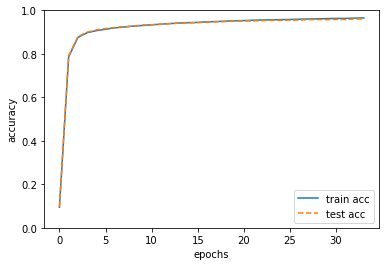

In [8]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normolize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 超参数
iters_num = 20000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# 平均每个epoch需要多少次迭代
iter_per_epoch = max(train_size / batch_size, 1)
print(f"iter_per_epoch: {iter_per_epoch}")

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 根据保存在grad中的梯度更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    
    train_loss_list.append(loss)

    # 计算每个epoch的准确率
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"epoch {i}, loss: {loss}, train acc: {train_acc}, test acc: {test_acc}")

import pickle
# 保存训练好的网络对象
with open('params.pkl', 'wb') as f:
    pickle.dump(network, f)
print('DONE')

# 绘制图形
import matplotlib.pyplot as plt

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()